# Project: Car Damage Detection

In [ ]:
!echo '{"username":"xxx","key":"xxx"}' > kaggle.json

In [ ]:
!env KAGGLE_CONFIG_DIR=. kaggle datasets download -d anujms/car-damage-detection

Dataset URL: https://www.kaggle.com/datasets/anujms/car-damage-detection
License(s): unknown
... resuming from 128654048 bytes (0 bytes left) ...
416 - Requested range not satisfiable


In [ ]:
!unzip car-damage-detection.zip > /dev/null

replace data1a/training/00-damage/0001.JPEG? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
!wget -O tag.xlsx https://spla.tools/tag-damaged-car.xlsx

--2024-04-21 01:17:59--  https://spla.tools/tag-damaged-car.xlsx
Resolving spla.tools (spla.tools)... 172.67.190.186, 104.21.20.2, 2606:4700:3037::ac43:beba, ...
Connecting to spla.tools (spla.tools)|172.67.190.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41197 (40K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘tag.xlsx’

tag.xlsx            100%[===================>]  40.23K  --.-KB/s    in 0s      

2024-04-21 01:18:00 (123 MB/s) - ‘tag.xlsx’ saved [41197/41197]



## Configs, adjust it here.

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
SEED = 559
TRAIN_VALID_SPLIT = 0.83
with_augment = True
train_loader = None
validation_loader = None

BASELINE_EPOCH = 10
BINARY_EPOCH = 20
MULTI_EPOCH = 25

# Utility functions (normally hide)

In [ ]:
from PIL import Image
import os
import cv2
import numpy as np
# import google.colab.patches as colab_patches
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from tqdm.std import trange
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Read the JPEG file

def read_image(filename):
    img = cv2.imread(filename)
    return img

def show_image(img: np.array):
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    # colab_patches.cv2_imshow(img)
    cv2.imshow('image', img)

In [ ]:
# Preprocess the image

def preprocess_image(img):
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    # Resize the image into H*W:
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    # Convert the image to RGB:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
# Convert all data to a big X

def convertXY(data):
    X = []
    y = []

    for x, tag in data:
        img = read_image(x)
        img = preprocess_image(img)
        X.append(img)
        if tag == '00-damage':
            y.append(1)
        else:
            y.append(0)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
# Custom class to add Gaussian noise
class GaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        img_np = np.array(img)  # Convert to NumPy array
        noise = np.random.normal(self.mean, self.std, img_np.shape)
        img_noisy = img_np + noise  # Add noise to image
        img_noisy = np.clip(img_noisy, 0, 255).astype(np.uint8)
        img_noisy_pil = Image.fromarray(img_noisy)  # Convert back to PIL Image
        return img_noisy_pil

# Step 1: Loading the data

### Data Loading

In [ ]:
df_tag = pd.read_excel('tag.xlsx')
df_tag.set_index('filename', inplace=True)
df_tag = df_tag.loc[:, ("Front", "Side", "Back")].fillna(0)

In [ ]:
# Create filename as index, then create a function to find the line:

def get_tags(filename):
    try:
        return df_tag.loc[filename].to_numpy()
    except KeyError:
        # print(filename + "not found")
        return np.zeros(3)

In [ ]:
get_tags('./data1a/training/00-damage/0001.JPEG')

array([0., 1., 1.])

In [ ]:
# Get the filename of training and validation set.

training_folder = './data1a/training'
validation_folder = './data1a/validation'
tags = ['00-damage', '01-whole']

datas = {}
multi_tags = {}
for i, m in enumerate((training_folder, validation_folder)):
    datas[i] = []
    multi_tags[i] = []
    for tag in tags:
        dir_name = os.path.join(m, tag)
        for filename in os.listdir(dir_name):
            datas[i].append([os.path.join(dir_name, filename), tag])
            multi_tags[i].append(get_tags(os.path.join(dir_name, filename.upper())))

In [ ]:
len(datas[0]), len(datas[1])

(1840, 460)

In [ ]:
X_train, y_train = convertXY(datas[0])
X_test, y_test = convertXY(datas[1])
ym_train = np.array(multi_tags[0])
ym_test = np.array(multi_tags[1])

### Create dataset

In [ ]:
class ImageData(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Define transformations, e.g., normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Instantiate the dataset
dataset = ImageData(X_train, y_train, transform=transform)

In [ ]:
picked = np.random.choice(X_train.shape[0], int(X_train.shape[0] * 0.2), replace=False)
X_train[picked].shape

(368, 224, 224, 3)

In [ ]:
if with_augment:
    transform_augmented = transforms.Compose([
        GaussianNoise(std=0.05),  # Add Gaussian noise
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    from torch.utils.data import ConcatDataset
    # random pick X_train and y_train values
    picked = np.random.choice(X_train.shape[0], int(X_train.shape[0] * 0.2), replace=False)
    dataset_aug = ImageData(X_train[picked], y_train[picked], transform=transform_augmented)
    dataset = ConcatDataset([dataset, dataset_aug])

In [ ]:
# Define the split sizes
total_images = len(dataset)
train_size = int(TRAIN_VALID_SPLIT * total_images)
validation_size = total_images - train_size

In [ ]:
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

### Here are some function related to model training, testing and plotting.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def train(model, criterion, optimizer, epochs=5, train_loader=train_loader, validation_loader=validation_loader, model_type="binary", threshold=0.50):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1} / {epochs}')
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            if model_type == "binary":
                _, preds = torch.max(outputs.data, 1)
            elif model_type == "multi" or model_type == "baseline":
                outputs = outputs.float()
                labels = labels.float()
                preds = (outputs.data >= threshold).float()
            else:
                raise ValueError("Invalid model type")
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        if model_type == "multi":
            epoch_acc /= 3.0
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.cpu())

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in tqdm(validation_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                if model_type == "binary":
                    _, preds = torch.max(outputs.data, 1)
                elif model_type == "multi" or model_type == "baseline":
                    outputs = outputs.float()
                    labels = labels.float()
                    preds = (outputs.data >= threshold).float()
                else:
                    raise ValueError("Invalid model type")
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(validation_loader.dataset)
        val_acc = val_corrects.double() / len(validation_loader.dataset)
        if model_type == "multi":
            val_acc /= 3.0
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.cpu())

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, (train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [ ]:
# Confusion matrix on test_dataset

def test(model, test_loader, model_type="binary", threshold=0.5):
    model.eval()
    confusion_matrix = np.zeros((2, 2))
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            if model_type == "binary":
                _, predicted = torch.max(outputs.data, 1)
            else: # For baseline model
                outputs = outputs.float()
                labels = labels.int()
                predicted = (outputs.data >= threshold).int()
            for i, label in enumerate(labels):
                confusion_matrix[label.item(), predicted[i].item()] += 1

    return confusion_matrix


In [ ]:
def test_multi(model, test_loader, threshold=0.5):
    all_correct_cnt = 0
    damaged_cnt = 0
    wrong_cnt = 0
    all_cnt = 0
    correct_cnt = 0
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = (outputs.data >= threshold).float()
            for i, label in enumerate(labels):
                max_arg = torch.argmax(outputs[i])
                # if there is "1" in the label tensor
                if torch.sum(label) > 0:
                    damaged_cnt += 1
                if label[max_arg] == 1:
                    correct_cnt += 1
                predicted_it = predicted.data[i]
                label_it = label
                wrong_cnt += torch.sum(predicted_it != label_it) / label.size(0)
                all_cnt += 1
                # print(predicted_it, label_it)
                if torch.equal(predicted_it, label_it):
                    all_correct_cnt += 1

    return all_correct_cnt, wrong_cnt, all_cnt, correct_cnt, damaged_cnt

In [ ]:
def plot_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history):
    # Plot the loss history and the accuracy history into 2 subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    x_epochs = np.arange(1, len(train_loss_history) + 1)
    ax1.plot(x_epochs, train_loss_history, label='Training Loss')
    ax1.plot(x_epochs, val_loss_history, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(x_epochs, train_acc_history, label='Training Accuracy')
    ax2.plot(x_epochs, val_acc_history, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [ ]:
def plot_roc(model, test_loader, thresholds=np.linspace(0, 1, 100)):
    model.eval()
    tps = np.zeros_like(thresholds)
    fps = np.zeros_like(thresholds)
    tns = np.zeros_like(thresholds)
    fns = np.zeros_like(thresholds)
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            for i, threshold in enumerate(thresholds):
                predicted = (outputs.data >= threshold).float()
                tp = torch.sum(predicted * labels).cpu()
                fp = torch.sum(predicted * (1 - labels)).cpu()
                tn = torch.sum((1 - predicted) * (1 - labels)).cpu()
                fn = torch.sum((1 - predicted) * labels).cpu()
                tps[i] += tp.item()
                fps[i] += fp.item()
                tns[i] += tn.item()
                fns[i] += fn.item()

    fprs = fps / (fps + tns)
    tprs = tps / (tps + fns)
    plt.plot(fprs, tprs)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

# Section 2: Binary classification (damaged or not)

In [ ]:
# Binary dataset for testing

test_dataset = ImageData(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Comparisons between different models

Comparing different models

### Model 0: Baseline

In [ ]:
class Baseline(nn.Module):
    # finished using GPT-4
    def __init__(self):
        super(Baseline, self).__init__()
        # First convolutional layer with leaky ReLU activation
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)  # Assuming 3-channel input (e.g., RGB)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 max pooling
        # Second convolutional layer with leaky ReLU activation
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        # Third convolutional layer with leaky ReLU activation
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Fully connected (dense) layer
        self.fc1 = nn.Linear(32 * 28 * 28, 128)  # Flattening requires knowing the output dimensions
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification with one output

    def forward(self, x):
        # Apply first convolution, then leaky ReLU activation
        x = F.leaky_relu(self.conv1(x), negative_slope=0.005)
        # Apply pooling
        x = self.pool(x)
        # Apply second convolution, then leaky ReLU
        x = F.leaky_relu(self.conv2(x), negative_slope=0.005)
        # Apply pooling
        x = self.pool(x)
        # Apply third convolution, then leaky ReLU
        x = F.leaky_relu(self.conv3(x), negative_slope=0.005)
        # Apply pooling
        x = self.pool(x)
        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)  # Flattening
        # Fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer with sigmoid activation
        x = torch.sigmoid(self.fc2(x))
        x = x.squeeze()
        return x

In [ ]:
# Create the model
model = Baseline()
model = model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model, history = train(model, criterion, optimizer, epochs=BASELINE_EPOCH, train_loader=train_loader, validation_loader=validation_loader, model_type='baseline')

Epoch 1 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:03<00:00, 14.86it/s]


Training Loss: 0.6875 Acc: 0.6130


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.33it/s]


Validation Loss: 0.5768 Acc: 0.6995
Epoch 2 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 30.01it/s]


Training Loss: 0.5338 Acc: 0.7282


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.02it/s]


Validation Loss: 0.5526 Acc: 0.7234
Epoch 3 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 28.50it/s]


Training Loss: 0.4894 Acc: 0.7653


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.11it/s]


Validation Loss: 0.5137 Acc: 0.7394
Epoch 4 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.82it/s]


Training Loss: 0.4317 Acc: 0.7997


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 32.11it/s]


Validation Loss: 0.4844 Acc: 0.7793
Epoch 5 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 26.82it/s]


Training Loss: 0.3779 Acc: 0.8259


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 32.02it/s]


Validation Loss: 0.6138 Acc: 0.7340
Epoch 6 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.33it/s]


Training Loss: 0.3342 Acc: 0.8548


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.69it/s]


Validation Loss: 0.5058 Acc: 0.7500
Epoch 7 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 26.73it/s]


Training Loss: 0.2716 Acc: 0.8794


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.76it/s]


Validation Loss: 0.5560 Acc: 0.7846
Epoch 8 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 27.35it/s]


Training Loss: 0.2548 Acc: 0.8930


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.11it/s]


Validation Loss: 0.5178 Acc: 0.7793
Epoch 9 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 28.23it/s]


Training Loss: 0.2188 Acc: 0.9154


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.03it/s]


Validation Loss: 0.5423 Acc: 0.7686
Epoch 10 / 10


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 28.04it/s]


Training Loss: 0.1954 Acc: 0.9323


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.86it/s]

Validation Loss: 0.6862 Acc: 0.7420


In [ ]:
# Save model
torch.save(model.state_dict(), './models/baseline.pth')

In [ ]:
test(model, test_loader, model_type='baseline')

Testing: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 72.54it/s]


array([[203.,  27.],
       [ 68., 162.]])

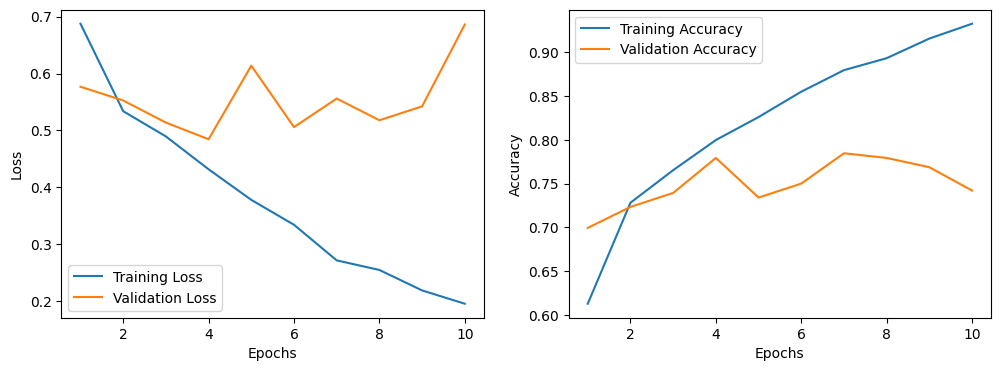

In [ ]:
plot_history(*history)

Testing: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 22.13it/s]


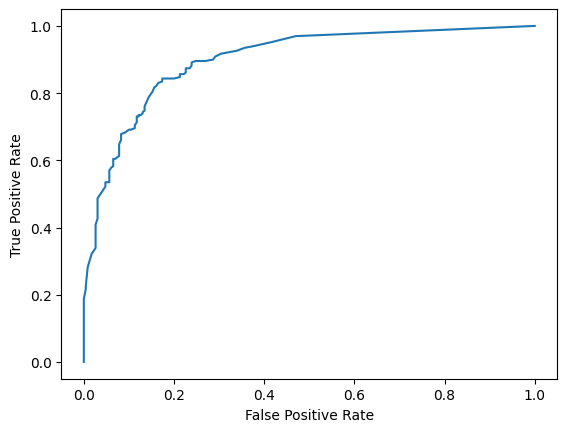

In [ ]:
plot_roc(model, test_loader)

### Model 1: MobileNet-v2

In [ ]:
def create_mobilenet_binary_classifier(**kwargs):
    model = models.mobilenet_v2(**kwargs)
    model.classifier = nn.Sequential(
        nn.Dropout(0.15),
        nn.Linear(model.classifier[1].in_features, 2)  # Change to 3 outputs
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model

In [ ]:
# Create the model
model = create_mobilenet_binary_classifier(pretrained=True, width_mult=1.0)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
model, history = train(model, criterion, optimizer, epochs=BINARY_EPOCH, train_loader=train_loader, validation_loader=validation_loader)

Epoch 1 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.34it/s]


Training Loss: 0.3731 Acc: 0.8297


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.52it/s]


Validation Loss: 0.3662 Acc: 0.8431
Epoch 2 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.83it/s]


Training Loss: 0.2074 Acc: 0.9219


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.51it/s]


Validation Loss: 0.2069 Acc: 0.9016
Epoch 3 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.82it/s]


Training Loss: 0.1848 Acc: 0.9301


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.97it/s]


Validation Loss: 0.3954 Acc: 0.8165
Epoch 4 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.84it/s]


Training Loss: 0.1739 Acc: 0.9290


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.79it/s]


Validation Loss: 0.2569 Acc: 0.9016
Epoch 5 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.74it/s]


Training Loss: 0.1236 Acc: 0.9498


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.19it/s]


Validation Loss: 0.3565 Acc: 0.9122
Epoch 6 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.84it/s]


Training Loss: 0.1373 Acc: 0.9514


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.12it/s]


Validation Loss: 0.3091 Acc: 0.8883
Epoch 7 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.63it/s]


Training Loss: 0.1087 Acc: 0.9552


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.05it/s]


Validation Loss: 0.3085 Acc: 0.8431
Epoch 8 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.85it/s]


Training Loss: 0.0884 Acc: 0.9667


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.42it/s]


Validation Loss: 0.6977 Acc: 0.8085
Epoch 9 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.51it/s]


Training Loss: 0.1294 Acc: 0.9520


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.53it/s]


Validation Loss: 0.2881 Acc: 0.8670
Epoch 10 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.66it/s]


Training Loss: 0.1040 Acc: 0.9580


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.27it/s]


Validation Loss: 0.3297 Acc: 0.8883
Epoch 11 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.38it/s]


Training Loss: 0.0785 Acc: 0.9700


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.37it/s]


Validation Loss: 0.3174 Acc: 0.9096
Epoch 12 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.65it/s]


Training Loss: 0.1017 Acc: 0.9607


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.80it/s]


Validation Loss: 0.3759 Acc: 0.8617
Epoch 13 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.57it/s]


Training Loss: 0.0777 Acc: 0.9733


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.25it/s]


Validation Loss: 0.2031 Acc: 0.9202
Epoch 14 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.25it/s]


Training Loss: 0.0524 Acc: 0.9814


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.54it/s]


Validation Loss: 0.2840 Acc: 0.9122
Epoch 15 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.84it/s]


Training Loss: 0.2305 Acc: 0.9127


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.87it/s]


Validation Loss: 0.4413 Acc: 0.8191
Epoch 16 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.79it/s]


Training Loss: 0.1249 Acc: 0.9558


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.78it/s]


Validation Loss: 0.2668 Acc: 0.8963
Epoch 17 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.57it/s]


Training Loss: 0.0687 Acc: 0.9754


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.85it/s]


Validation Loss: 0.3867 Acc: 0.8936
Epoch 18 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.61it/s]


Training Loss: 0.0805 Acc: 0.9700


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.81it/s]


Validation Loss: 0.2731 Acc: 0.9016
Epoch 19 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.71it/s]


Training Loss: 0.1011 Acc: 0.9602


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.25it/s]


Validation Loss: 0.2260 Acc: 0.9122
Epoch 20 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:04<00:00, 13.71it/s]


Training Loss: 0.0577 Acc: 0.9809


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.72it/s]

Validation Loss: 0.2999 Acc: 0.9043


In [ ]:
# Save model
torch.save(model.state_dict(), './models/mobilenet-v2.pth')

In [ ]:
test(model, test_loader)

Testing: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.97it/s]


array([[217.,  13.],
       [ 11., 219.]])

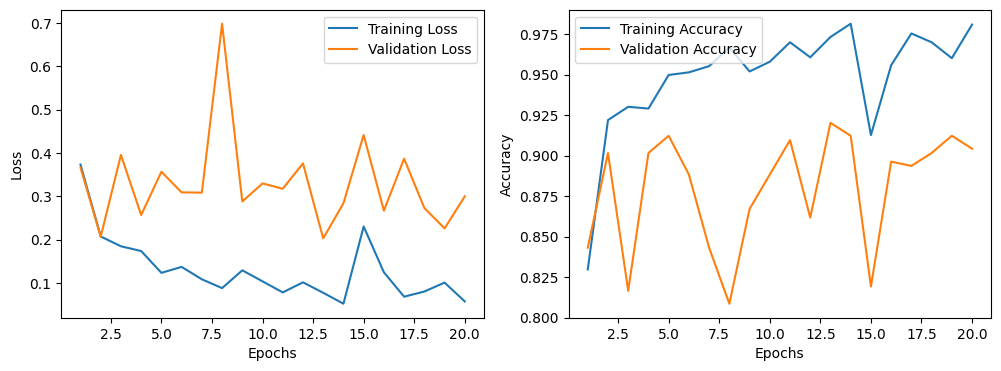

In [ ]:
plot_history(*history)

### Model 2: ResNet50

In [ ]:
def create_resnet50_binary_classifier(**kwargs):
    kwargs['weights'] = models.ResNet50_Weights.DEFAULT
    model = models.resnet50(**kwargs)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)
    model = model.to(device)
    return model

In [ ]:
# Create the model
model = create_resnet50_binary_classifier()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
model, history = train(model, criterion, optimizer, epochs=BINARY_EPOCH, train_loader=train_loader, validation_loader=validation_loader)

Epoch 1 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  7.16it/s]


Training Loss: 0.5595 Acc: 0.7445


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.27it/s]


Validation Loss: 0.4212 Acc: 0.8644
Epoch 2 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.17it/s]


Training Loss: 0.3573 Acc: 0.8548


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.22it/s]


Validation Loss: 0.2954 Acc: 0.8989
Epoch 3 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.24it/s]


Training Loss: 0.2767 Acc: 0.8892


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.89it/s]


Validation Loss: 0.2544 Acc: 0.9255
Epoch 4 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.17it/s]


Training Loss: 0.2245 Acc: 0.9083


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.41it/s]


Validation Loss: 0.2108 Acc: 0.9335
Epoch 5 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.15it/s]


Training Loss: 0.1680 Acc: 0.9405


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.67it/s]


Validation Loss: 0.1856 Acc: 0.9441
Epoch 6 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.12it/s]


Training Loss: 0.1438 Acc: 0.9514


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.31it/s]


Validation Loss: 0.2093 Acc: 0.9202
Epoch 7 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.55it/s]


Training Loss: 0.1088 Acc: 0.9651


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.70it/s]


Validation Loss: 0.1777 Acc: 0.9415
Epoch 8 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.09it/s]


Training Loss: 0.1008 Acc: 0.9640


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.36it/s]


Validation Loss: 0.1944 Acc: 0.9229
Epoch 9 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.22it/s]


Training Loss: 0.0884 Acc: 0.9711


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.96it/s]


Validation Loss: 0.1771 Acc: 0.9388
Epoch 10 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.15it/s]


Training Loss: 0.0700 Acc: 0.9793


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.78it/s]


Validation Loss: 0.1736 Acc: 0.9495
Epoch 11 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.03it/s]


Training Loss: 0.0665 Acc: 0.9793


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.07it/s]


Validation Loss: 0.1563 Acc: 0.9601
Epoch 12 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.15it/s]


Training Loss: 0.0548 Acc: 0.9869


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.53it/s]


Validation Loss: 0.1514 Acc: 0.9468
Epoch 13 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.07it/s]


Training Loss: 0.0479 Acc: 0.9864


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.80it/s]


Validation Loss: 0.1559 Acc: 0.9521
Epoch 14 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.16it/s]


Training Loss: 0.0452 Acc: 0.9874


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.28it/s]


Validation Loss: 0.1642 Acc: 0.9521
Epoch 15 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:06<00:00,  8.30it/s]


Training Loss: 0.0420 Acc: 0.9864


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.03it/s]


Validation Loss: 0.1480 Acc: 0.9601
Epoch 16 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.18it/s]


Training Loss: 0.0385 Acc: 0.9891


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.61it/s]


Validation Loss: 0.1437 Acc: 0.9681
Epoch 17 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.22it/s]


Training Loss: 0.0341 Acc: 0.9896


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.49it/s]


Validation Loss: 0.1563 Acc: 0.9574
Epoch 18 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.06it/s]


Training Loss: 0.0436 Acc: 0.9858


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.96it/s]


Validation Loss: 0.1509 Acc: 0.9601
Epoch 19 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.23it/s]


Training Loss: 0.0361 Acc: 0.9880


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.05it/s]


Validation Loss: 0.1418 Acc: 0.9548
Epoch 20 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  8.20it/s]


Training Loss: 0.0331 Acc: 0.9896


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.05it/s]

Validation Loss: 0.1772 Acc: 0.9495


In [ ]:
# Save model
torch.save(model.state_dict(), './models/resnet50.pth')

In [ ]:
test(model, test_loader)

Testing: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 19.12it/s]


array([[215.,  15.],
       [ 13., 217.]])

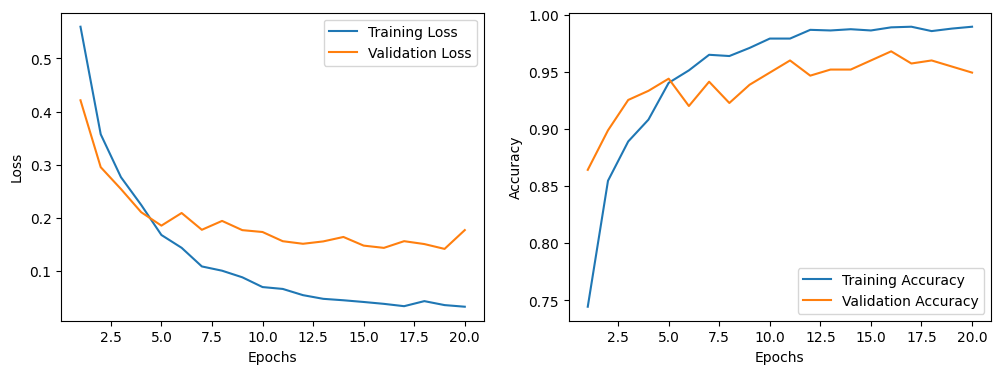

In [ ]:
plot_history(*history)

### Model 3: DenseNet121

In [ ]:
def create_densenet121_binary_classifier(**kwargs):
    model = models.densenet121(**kwargs)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    model = model.to(device)
    return model

In [ ]:
# Create the model
model = create_densenet121_binary_classifier(drop_rate=0.05, weights=models.DenseNet121_Weights.DEFAULT)
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
model, history = train(model, criterion, optimizer, epochs=BINARY_EPOCH, train_loader=train_loader, validation_loader=validation_loader)

Epoch 1 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.50it/s]


Training Loss: 0.4440 Acc: 0.7658


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.18it/s]


Validation Loss: 0.2148 Acc: 0.9043
Epoch 2 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.65it/s]


Training Loss: 0.2392 Acc: 0.9039


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.04it/s]


Validation Loss: 0.2181 Acc: 0.9069
Epoch 3 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.60it/s]


Training Loss: 0.1907 Acc: 0.9247


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.14it/s]


Validation Loss: 0.1495 Acc: 0.9362
Epoch 4 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.69it/s]


Training Loss: 0.1408 Acc: 0.9421


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.29it/s]


Validation Loss: 0.1655 Acc: 0.9229
Epoch 5 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.72it/s]


Training Loss: 0.0967 Acc: 0.9656


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.49it/s]


Validation Loss: 0.1715 Acc: 0.9255
Epoch 6 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.69it/s]


Training Loss: 0.0865 Acc: 0.9672


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.12it/s]


Validation Loss: 0.1317 Acc: 0.9441
Epoch 7 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.73it/s]


Training Loss: 0.0683 Acc: 0.9738


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.73it/s]


Validation Loss: 0.1635 Acc: 0.9388
Epoch 8 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.68it/s]


Training Loss: 0.0584 Acc: 0.9814


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.73it/s]


Validation Loss: 0.1415 Acc: 0.9468
Epoch 9 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.73it/s]


Training Loss: 0.0536 Acc: 0.9842


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.63it/s]


Validation Loss: 0.1523 Acc: 0.9574
Epoch 10 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.65it/s]


Training Loss: 0.0483 Acc: 0.9842


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.90it/s]


Validation Loss: 0.1516 Acc: 0.9362
Epoch 11 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.71it/s]


Training Loss: 0.0391 Acc: 0.9896


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.85it/s]


Validation Loss: 0.1516 Acc: 0.9415
Epoch 12 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.66it/s]


Training Loss: 0.0486 Acc: 0.9853


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.46it/s]


Validation Loss: 0.1748 Acc: 0.9388
Epoch 13 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.66it/s]


Training Loss: 0.0399 Acc: 0.9885


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.55it/s]


Validation Loss: 0.1609 Acc: 0.9441
Epoch 14 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.62it/s]


Training Loss: 0.0357 Acc: 0.9891


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.96it/s]


Validation Loss: 0.1369 Acc: 0.9601
Epoch 15 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.65it/s]


Training Loss: 0.0236 Acc: 0.9924


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.70it/s]


Validation Loss: 0.1577 Acc: 0.9388
Epoch 16 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.67it/s]


Training Loss: 0.0179 Acc: 0.9945


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.00it/s]


Validation Loss: 0.1231 Acc: 0.9654
Epoch 17 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.64it/s]


Training Loss: 0.0245 Acc: 0.9918


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.86it/s]


Validation Loss: 0.1178 Acc: 0.9681
Epoch 18 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.66it/s]


Training Loss: 0.0270 Acc: 0.9913


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.55it/s]


Validation Loss: 0.1353 Acc: 0.9548
Epoch 19 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.61it/s]


Training Loss: 0.0294 Acc: 0.9907


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.67it/s]


Validation Loss: 0.1832 Acc: 0.9309
Epoch 20 / 20


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:08<00:00,  6.60it/s]


Training Loss: 0.0176 Acc: 0.9934


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.55it/s]

Validation Loss: 0.1220 Acc: 0.9707


In [ ]:
# Save model
torch.save(model.state_dict(), './models/densenet121.pth')

In [ ]:
test(model, test_loader)

Testing: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 22.83it/s]


array([[217.,  13.],
       [ 12., 218.]])

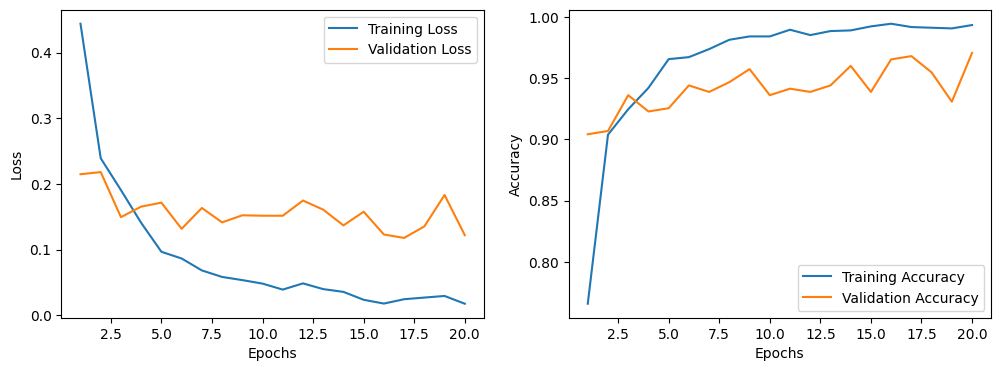

In [ ]:
plot_history(*history)

# Section 3: Multi-class classification

## Create multi-class dataset

In [ ]:
class MultiImageData(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
ym_train.shape

(1840, 3)

In [ ]:
multi_dataset = MultiImageData(X_train, ym_train, transform=transform)

In [ ]:
if with_augment:
    transform_augmented = transforms.Compose([
        GaussianNoise(std=0.05),  # Add Gaussian noise
        transforms.ToTensor(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    picked = np.random.choice(X_train.shape[0], int(X_train.shape[0] * 0.2), replace=False)
    multi_dataset_aug = ImageData(X_train[picked], ym_train[picked], transform=transform_augmented)
    multi_dataset = ConcatDataset([multi_dataset, multi_dataset_aug])

In [ ]:
# Define the split sizes
total_images = len(multi_dataset)
train_size = int(TRAIN_VALID_SPLIT * total_images)
validation_size = total_images - train_size

In [ ]:
train_dataset, val_dataset = random_split(multi_dataset, [train_size, validation_size])

train_multi_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_multi_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
multi_test_dataset = MultiImageData(X_test, ym_test, transform=transform)
test_multi_loader = DataLoader(multi_test_dataset, batch_size=32, shuffle=False)

## Using ResNet50

In [ ]:
def create_resnet50_multi_classifier(**kwargs):
    model = models.resnet50(**kwargs)
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 3),  # Final linear layer with num_outputs
        torch.nn.Sigmoid()  # Apply sigmoid activation
    )
    model = model.to(device)
    return model

In [ ]:
def create_mobilenet_multi_classifier(**kwargs):
    class ModifiedMobileNetV2(nn.Module):
        def __init__(self, mobilenet_v2):
            super(ModifiedMobileNetV2, self).__init__()
            self.mobilenet_v2 = mobilenet_v2

        def forward(self, x):
            x = self.mobilenet_v2(x)
            x = torch.sigmoid(x)  # Apply sigmoid to get outputs in range [0, 1]
            return x
    model0 = models.mobilenet_v2(**kwargs)
    model0.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model0.classifier[1].in_features, 3)  # Change to 3 outputs
    )
    model = ModifiedMobileNetV2(model0)
    model = model.to(device)
    return model

In [ ]:
# Model, criterion and optimizer
model = create_resnet50_multi_classifier(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# model = create_mobilenet_multi_classifier(weights=models.MobileNet_V2_Weights.DEFAULT, width_mult=1.0)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model, history = train(model, criterion, optimizer, epochs=MULTI_EPOCH, train_loader=train_multi_loader, validation_loader=validation_multi_loader, model_type='multi')

Epoch 1 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.79it/s]


Training Loss: 0.3962 Acc: 0.8191


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.19it/s]


Validation Loss: 0.4275 Acc: 0.8209
Epoch 2 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.95it/s]


Training Loss: 0.3179 Acc: 0.8501


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.57it/s]


Validation Loss: 0.4561 Acc: 0.8289
Epoch 3 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.56it/s]


Training Loss: 0.2677 Acc: 0.8781


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.35it/s]


Validation Loss: 0.2835 Acc: 0.8723
Epoch 4 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.40it/s]


Training Loss: 0.2298 Acc: 0.9054


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.82it/s]


Validation Loss: 0.6899 Acc: 0.8413
Epoch 5 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.47it/s]


Training Loss: 0.1951 Acc: 0.9168


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.43it/s]


Validation Loss: 0.2909 Acc: 0.8874
Epoch 6 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.48it/s]


Training Loss: 0.1654 Acc: 0.9341


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.79it/s]


Validation Loss: 0.3687 Acc: 0.8573
Epoch 7 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.40it/s]


Training Loss: 0.1272 Acc: 0.9483


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.16it/s]


Validation Loss: 0.3349 Acc: 0.8608
Epoch 8 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.50it/s]


Training Loss: 0.1201 Acc: 0.9531


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.12it/s]


Validation Loss: 0.3540 Acc: 0.8741
Epoch 9 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.43it/s]


Training Loss: 0.1171 Acc: 0.9518


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.48it/s]


Validation Loss: 0.5005 Acc: 0.8369
Epoch 10 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.45it/s]


Training Loss: 0.1095 Acc: 0.9556


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.21it/s]


Validation Loss: 0.3225 Acc: 0.8830
Epoch 11 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.51it/s]


Training Loss: 0.1349 Acc: 0.9487


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.60it/s]


Validation Loss: 0.4847 Acc: 0.8520
Epoch 12 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.37it/s]


Training Loss: 0.1272 Acc: 0.9487


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.42it/s]


Validation Loss: 0.4193 Acc: 0.8670
Epoch 13 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.51it/s]


Training Loss: 0.1048 Acc: 0.9583


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.69it/s]


Validation Loss: 0.4180 Acc: 0.8732
Epoch 14 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.46it/s]


Training Loss: 0.1009 Acc: 0.9627


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.91it/s]


Validation Loss: 0.2811 Acc: 0.8883
Epoch 15 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.55it/s]


Training Loss: 0.0658 Acc: 0.9742


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.00it/s]


Validation Loss: 0.3503 Acc: 0.8848
Epoch 16 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.48it/s]


Training Loss: 0.0606 Acc: 0.9783


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.90it/s]


Validation Loss: 0.3444 Acc: 0.8918
Epoch 17 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.30it/s]


Training Loss: 0.0540 Acc: 0.9813


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.14it/s]


Validation Loss: 0.3417 Acc: 0.8883
Epoch 18 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.25it/s]


Training Loss: 0.0573 Acc: 0.9782


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.78it/s]


Validation Loss: 0.4826 Acc: 0.8803
Epoch 19 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.56it/s]


Training Loss: 0.0633 Acc: 0.9720


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.94it/s]


Validation Loss: 0.3352 Acc: 0.8998
Epoch 20 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.37it/s]


Training Loss: 0.0655 Acc: 0.9733


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.67it/s]


Validation Loss: 0.3455 Acc: 0.8803
Epoch 21 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.57it/s]


Training Loss: 0.0602 Acc: 0.9769


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.81it/s]


Validation Loss: 0.3387 Acc: 0.8927
Epoch 22 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.43it/s]


Training Loss: 0.0591 Acc: 0.9774


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.67it/s]


Validation Loss: 0.3302 Acc: 0.8936
Epoch 23 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.61it/s]


Training Loss: 0.0568 Acc: 0.9763


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.72it/s]


Validation Loss: 0.3852 Acc: 0.8794
Epoch 24 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.46it/s]


Training Loss: 0.0514 Acc: 0.9811


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.87it/s]


Validation Loss: 0.3486 Acc: 0.8865
Epoch 25 / 25


Training: 100%|███████████████████████████████████████████████████████████████████| 58/58 [00:07<00:00,  7.53it/s]


Training Loss: 0.0743 Acc: 0.9720


Validation: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.79it/s]

Validation Loss: 0.3594 Acc: 0.8723


In [ ]:
all_correct_cnt, wrong_cnt, all_cnt, correct_cnt, damaged_cnt = test_multi(model, test_multi_loader)
print(f"All correct: {all_correct_cnt} / {all_cnt} = {all_correct_cnt / all_cnt}")
print(f"Wrong: {wrong_cnt} / {all_cnt} = {wrong_cnt / all_cnt}")
print(f"Correct: {correct_cnt} / {damaged_cnt} = {correct_cnt / damaged_cnt}")

Testing: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 21.14it/s]

All correct: 303 / 460 = 0.658695652173913
Wrong: 69.66666412353516 / 460 = 0.1514492630958557
Correct: 167 / 229 = 0.7292576419213974


Testing: 100%|████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.67s/it]


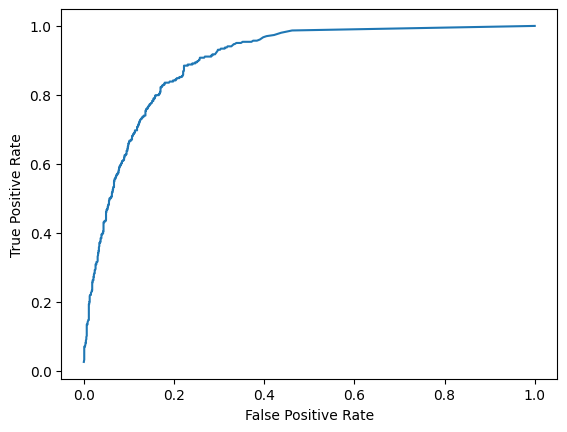

In [ ]:
plot_roc(model, test_multi_loader, thresholds=np.arange(0, 0.9998, 0.0002))